<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Introduction to the Lithology and LithoLayers objects

Lithology and LithoLayers are two Landlab components meant to make it easier to work with spatially variable lithology that produces spatially variable parameter values (e.g. stream power erodability or diffusivity). 

This tutorial is meant for users who have some experience using Landlab components.

In this tutorial we will explore the creation of spatially variable lithology and its impact on the evolution of topography. After an introductory example that will let you see how LithoLayers works, we will work through two more complicated examples. In the first example, we use the LithoLayers to erode either dipping layeres or an anticline. Then we will use Lithology to create inverted topography. 

We will use [xarray](https://xarray.pydata.org/en/stable/) to store and annotate our model output. While we won't extensively discuss the use of xarray, some background will be provided. 

To start, we will import the necessary modules. A note: this tutorial uses the [HoloViews package](http://holoviews.org) for visualization. This package is a great tool for dealing with multidimentional annotated data (e.g. an xarray dataset). If you get an error on import, consider updating dask (this is what the author needed to do in April 2018). You will also need to have the [Bokeh](https://bokeh.pydata.org/en/latest/) and [Matplotlib](https://matplotlib.org) packages installed.

In testing we've seen some users have a warning raised related to the Matplotlib backend. In our testing it was OK to ignore these errors. 

In [9]:
#import warnings

#warnings.filterwarnings("ignore")

import matplotlib
import numpy as np
import xarray as xr

#matplotlib.use("Agg")

#%matplotlib inline

#import holoviews as hv

#hv.notebook_extension("matplotlib")

from landlab import RasterModelGrid
from landlab.components import (
    FastscapeEroder,
    FlowAccumulator,
    LinearDiffuser,
    LithoLayers,
    Lithology,
)
print("made it to end")

made it to end


## Part 1: Creating layered rock

First we will create an instance of a LithoLayers to learn how this component works. Both LithoLayers and Lithology work closely with a Landlab ModelGrid, storing information about rock type at each grid node. 

To create LithoLayers you need the following information:

1. A model grid that has the field `'topographic__elevation'` already created. 
2. A list of elevations, called `'layer_elevations'` that the bottom of your layers will go through at specified plan-view anchor point (default value for the anchor point is (x, y) = (0, 0)), and a list of rock type IDs that indicate the rock type of that layer. When `'layer_elevations'` is negative that means that the layer goes through the anchor point above the topographic surface. These layers will be created where they extend below the topographic surface.
3. A dictionary of rock property attributes that maps a rock ID type to property values.
4. A functional form in x and y that defines the shape of your surface. 

The use of this function form makes it possible for any function of x and y to be passed to LithoLayers.

Both the Lithology and LithoLayers components then know the rock type ID of all the material in the 'block of rock' you have specified. This can be used to continuously know the value of specified rock properties at the topographic surface, even as the rock is eroded, uplifted, or new rock is deposited. 

In this tutorial we will first make an example to help build intuition and then do two more complex examples. Most of the functionality of Lithology and LithoLayers is shown in this tutorial, but if you want to read the full component documentation for LithoLayers, it can be found [here](https://landlab.readthedocs.io/en/release/landlab.components.lithology.html). Links to both components documentation can be found at the bottom of the tutorial.

First, we create a small RasterModelGrid with topography. 

In [ ]:
mg = RasterModelGrid((10, 15))
z = mg.add_zeros("topographic__elevation", at="node")

Next we make our layer elevations. We will make 20 layers that are 5 meters thick. Note that here, as with most Landlab components, there are no default units. At the anchor point, half of the layers will be above the ground (`'layer_elevations'`  will have negative values) and half will be below the ground (`'layer_elevations'` have positive values). 

We will make this with the [`np.arange`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html) function. We will also make the bottom layer really really thick so that we won't be able to erode through through it. 

In [ ]:
layer_elevations = 5.0 * np.arange(-10, 10)

# we create a bottom layer that is very thick.
layer_elevations[-1] = layer_elevations[-2] + 100

Next we create an array that represents our rock type ID values. We will create alternating layers of four types of rock by making an array with alternating `0`s `1`s `2`s and `3`s with the [np.tile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tile.html) function. 

In [ ]:
layer_ids = np.tile([0, 1, 2, 3], 5)

Our dictionary containing rock property attributes has the following form:

In [ ]:
attrs = {"K_sp": {0: 0.0003, 1: 0.0001, 2: 0.0002, 3: 0.0004}}

`'K_sp'` is the property that we want to track through the layered rock, `0`, `1`, `2`, `3` are the rock type IDs, and `0.0003` and `0.0001` are the values for `'K_sp'`  for the rock types `0` and `1`. 

The rock type IDs are unique identifiers for each type of rock. A particular rock type may have many properties (e.g. `'K_sp'`, `'diffusivity'`, and more). You can either specify all the possible rock types and attributes when you instantiate the LithoLayers component, or you can add new ones with the [`lith.add_rock_type`](https://landlab.readthedocs.io/en/release/landlab.components.lithology.html#landlab.components.lithology.lithology.Lithology.add_rock_type) or [`lith.add_property`](https://landlab.readthedocs.io/en/release/landlab.components.lithology.html#landlab.components.lithology.lithology.Lithology.add_property) built in functions.

Finally, we define our function. Here we will use a [lambda expression](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to create a small anonymous function. In this case we define a function of `x` and `y` that returns the value `x + (2. * y)`. The LithoLayers component will check that this function is a function of two variables and that when passed two arrays of size number-of-nodes it returns an array of size number-of-nodes.

This means that planar rock layers will dip into the ground to the North-North-East. By changing this functional form, we can make more complicated rock layers.

Finally we construct our LithoLayers component by passing the correct arguments.

In [ ]:
lith = LithoLayers(
    mg, layer_elevations, layer_ids, function=lambda x, y: x + (2.0 * y), attrs=attrs
)

LithoLayers will make sure that the model grid has at-node grid fields with the layer attribute names. In this case, this means that the model grid will now include a grid field called `'K_sp'` and a field called `'rock_type__id'`. We can plot these with the Landlab [imshow](http://landlab.readthedocs.io/en/release/landlab.plot.html#landlab.plot.imshow.imshow_grid) function. 

note, I had to have set up like this for this figure to appear:

`#import warnings`

#warnings.filterwarnings("ignore")

import matplotlib
import numpy as np
#import xarray as xr

#matplotlib.use("Agg")

#%matplotlib inline

#import holoviews as hv

#hv.notebook_extension("matplotlib")

from landlab import RasterModelGrid
from landlab.components import (
    FastscapeEroder,
    FlowAccumulator,
    LinearDiffuser,
    LithoLayers,
    Lithology,
)`

In [ ]:
mg.imshow("rock_type__id", cmap="viridis")

As you can see, we have layers that strike East-South-East. Since we can only see the surface expression of the layers, we can't infer the dip direction or magnitude from the plot alone. 

If the topographic surface erodes, then you will want to update LithoLayers. Like most Landlab components, LithoLayers uses a `run_one_step` method to update. 

Next we will erode the topography by decrementing the variable `z`, which points to the topographic elevation of our model grid, by an amount 1. In a landscape evolution model, this would typically be done by running the `run_one_step` method for each of the process components in the model. If the rock mass is being advected up or down by an external force (e.g. tectonic rock uplift), then then advection must be specified. The `dz_advection` argument can be a single value or an array of size number-of-nodes. 

In [ ]:
z -= 1.0
dz_ad = 0.0
lith.dz_advection = dz_ad
lith.run_one_step()

We can re-plot the value of `'K_sp'`. We will see that the location of the surface expression of the rock layers has changed. As we expect, the location has changed in a way that is consistent with layers dipping to the NNE. 

In [ ]:
mg.imshow("rock_type__id", cmap="viridis")

Anytime material is added, LithoLayers or Lithology needs to know the type of rock that has been added. LithoLayers and Lithology do not assume to know the correct rock type ID and thus require that the user specify it with the `rock_id` keyword argument. In the `run_one_step` function, both components will check to see if any deposition has occured. If deposition occurs **and** this argument is not passed, then an error will be raised. 

For example here we add 1 m of topographic elevation and do not advect the block of rock up or down. When we run `lith.run_one_step` we specify that the type of rock has id `0`. 

In [ ]:
z += 1.0
dz_ad = 0.0

lith.dz_advection = dz_ad
lith.rock_id = 0

lith.run_one_step()

When we plot the value of the rock type ID at the surface, we find that it is now all purple, the color of rock type zero. 

In [ ]:
mg.imshow("rock_type__id", cmap="viridis", vmin=0, vmax=3)

The value passed to the `rock_id` keyword argument can be either a single value (as in the second to last example) or an array of length number-of-nodes. This option permits a user to indicate that more than one type of rock is deposited in a single time step. 

Next we will add a 2 m thick layer that is type `1` for x values less than or equal to 6 and type `2` for all other locations. 

In [ ]:
z += 2.0
dz_ad = 0.0
spatially_variable_rock_id = mg.ones("node")
spatially_variable_rock_id[mg.x_of_node > 6] = 2

lith.dz_advection = dz_ad
lith.rock_id = spatially_variable_rock_id

lith.run_one_step()
mg.imshow("rock_type__id", cmap="viridis", vmin=0, vmax=3)

As you can see this results in the value of rock type at the surface being about half rock type `1` and about half rock type `2`. Next we will create an xarray dataset that has 3D information about our Lithology to help visualize the layers in space. We will use the `rock_cube_to_xarray` method of the LithoLayers component. 

We will then convert this xarray dataset into a HoloViews dataset so we can visualize the result. 

As you can see the LithoLayers has a value of rock types `1` and `2` at the surface, then a layer of `0` below, and finally changes to alternating layers. 

In [ ]:
import xarray as xr

matplotlib.use("Agg")

%matplotlib inline
import holoviews as hv
hv.notebook_extension("matplotlib")

In [ ]:
ds = lith.rock_cube_to_xarray(np.arange(30))
hvds_rock = hv.Dataset(ds.rock_type__id)

%opts Image style(cmap='viridis') plot[colorbar=True]
hvds_rock.to(hv.Image, ["x", "y"])

The slider allows us to change the depth below the topographic surface.

We can also plot the cube of rock created with LithoLayers as a cross section. In the cross section we can see the top two layers we made by depositing rock and then dipping layers of alternating rock types. 

In [ ]:
%opts Image style(cmap='viridis') plot[colorbar=True, invert_yaxis=True]
hvds_rock.to(hv.Image, ["x", "z"])

Hopefuly this gives you a sense of how LithoLayers works. The next two blocks of code have all the steps we just worked through in one place. 

Try modifying the layer thicknesses, the size of the grid, the function used to create the form of the layers, the layers deposited and eroded, and the location of the anchor point to gain intuition for how you can use LithoLayers to create different types of layered rock. 

In [ ]:
# Parameters that control the size and shape of the model grid
number_of_rows = 50
number_of_columns = 50
dx = 1

# Parameters that control the LithoLayers

# the layer thicknesses
layer_thickness = 50.0

# the location of the anchor point
x0 = 25
y0 = 25

# the resolution at which you sample to create the plan view and cros-section view figures.
sample_depths = np.arange(0, 30, 1)

# create the model grid
mg = RasterModelGrid((number_of_rows, number_of_columns), dx)
z = mg.add_zeros("topographic__elevation", at="node")

# set up LithoLayers inputs
layer_ids = np.tile([0, 1, 2, 3], 5)
layer_elevations = layer_thickness * np.arange(-10, 10)
layer_elevations[-1] = layer_elevations[-2] + 100
attrs = {"K_sp": {0: 0.0003, 1: 0.0001, 2: 0.0002, 3: 0.0004}}

# create LithoLayers
lith = LithoLayers(
    mg,
    layer_elevations,
    layer_ids,
    x0=x0,
    y0=y0,
    function=lambda x, y: (0.5 * x) ** 2 + (0.5 * y) ** 2,
    attrs=attrs,
)

# deposity and erode
dz_ad = 0.0

z -= 1.0
lith.dz_advection = dz_ad
lith.run_one_step()

z += 1.0
lith.dz_advection = dz_ad
lith.rock_id = 0
lith.run_one_step()

z += 2.0
spatially_variable_rock_id = mg.ones("node")
spatially_variable_rock_id[mg.x_of_node > 6] = 2
lith.dz_advection = dz_ad
lith.rock_id = spatially_variable_rock_id
lith.run_one_step()

# get the rock-cube data structure and plot
ds = lith.rock_cube_to_xarray(sample_depths)
hvds_rock = hv.Dataset(ds.rock_type__id)

# make a plan view image
%opts Image style(cmap='viridis') plot[colorbar=True]
hvds_rock.to(hv.Image, ["x", "y"])

You can also make a cross section of this new LithoLayers component. 

In [ ]:
%opts Image style(cmap='viridis') plot[colorbar=True, invert_yaxis=True]
hvds_rock.to(hv.Image, ["x", "z"])

## Part 2: Creation of a landscape evolution model with LithoLayers


In this next section, we will run LithoLayers with components used for a simple Landscape Evolution Model. 

We will start by creating the grid.

In [2]:
mg = RasterModelGrid((50, 30), 400)
z = mg.add_zeros("topographic__elevation", at="node")
random_field = 0.01 * np.random.randn(mg.size("node"))
z += random_field - random_field.min()

Next we set all the parameters for LithoLayers. Here we have two types of rock with different erodabilities. 

In [3]:
attrs = {"K_sp": {0: 0.0003, 1: 0.0001}}

z0s = 50 * np.arange(-20, 20)
z0s[-1] = z0s[-2] + 10000

ids = np.tile([0, 1], 20)

There are three functional forms that you can choose between. Here we define each of them. 

In [4]:
# Anticline


def anticline_func(x, y):
    return (0.002 * x) ** 2 + (0.001 * y) ** 2


# Shallow dips
def shallow_func(x, y):
    return (0.001 * x) + (0.003 * y)


# Steeper dips
def steep_func(x, y):
    return (0.01 * x) + (0.01 * y)

The default option is to make an anticline, but you can comment/uncomment lines to choose a different functional form. 

In [5]:
# Anticline
lith = LithoLayers(
    mg, z0s, ids, x0=6000, y0=10000, function=anticline_func, attrs=attrs
)

# Shallow dips
# lith = LithoLayers(mg, z0s, ids, function=shallow_func, attrs=attrs)

# Steeper dips
# lith = LithoLayers(mg, z0s, ids, function=steep_func, attrs=attrs)

Now that we've created LithoLayers, model grid fields for each of the LithoLayers attributes exist and have been set to the values of the rock exposed at the surface. 

Here we plot the value of `'K_sp'` as a function of the model grid. 

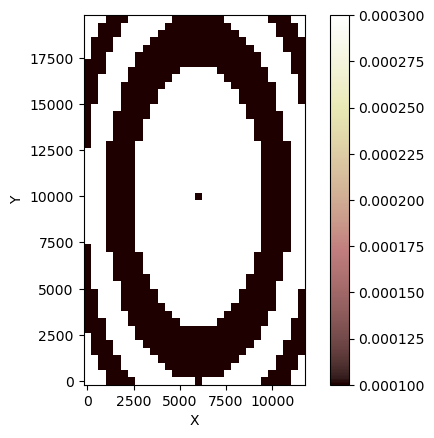

In [6]:
mg.imshow("K_sp")

As you can see (in the default anticline option) we have concentric elipses of stronger and weaker rock. 

Next, lets instantiate a FlowAccumulator and a FastscapeEroder to create a simple landscape evolution model. 

We will point the FastscapeEroder to the model grid field `'K_sp'` so that it will respond to the spatially variable erodabilities created by LithoLayers. 

In [7]:
nts = 300
U = 0.001
dt = 1000

fa = FlowAccumulator(mg)
sp = FastscapeEroder(mg, K_sp="K_sp")

Before we run the model we will also instatiate an xarray dataset used to store the output of our model through time for visualization. 

The next block may look intimidating, but I'll try and walk you through what it does. 

[xarray](https://xarray.pydata.org/en/stable/) allows us to create a container for our data and label it with information like units, dimensions, short and long names, etc.  xarray gives all the tools for dealing with N-dimentional data provided by python packages such as [numpy](http://www.numpy.org), the labeling and named indexing power of the [pandas](https://pandas.pydata.org) package, and the data-model of the [NetCDF file](https://www.unidata.ucar.edu/software/netcdf/).

This means that we can use xarray to make a "self-referential" dataset that contains all of the variables and attributes that describe what each part is and how it was made. In this application, we won't make a fully self-referential dataset, but if you are interested in this, check out the [NetCDF best practices](https://www.unidata.ucar.edu/software/netcdf/docs/BestPractices.html). 

Important for our application is that later on we will use the [HoloViews package](http://holoviews.org) for visualization. This package is a great tool for dealing with multidimentional annotated data and will do things like automatically create nice axis labels with units. However, in order for it to work, we must first annotate our data to include this information.

Here we create an xarray Dataset with two variables `'topographic__elevation'` and `'rock_type__id'` and three dimensions `'x'`, `'y'`, and `'time'`. 

We pass xarray two dictionaries, one with information about the data variabiables (`data_vars`) and one with information about the coordinate system (`coords`). For each data variable or coordinate, we pass a tuple of three items: `(dims, data, atts)`. The first element is a tuple of the name of the dimensions, the second element is the data, an the third is a dictionary of attributes. 

In [10]:
ds = xr.Dataset(
    data_vars={
        "topographic__elevation": (
            ("time", "y", "x"),  # tuple of dimensions
            np.empty((nts, mg.shape[0], mg.shape[1])),  # n-d array of data
            {
                "units": "meters",  # dictionary with data attributes
                "long_name": "Topographic Elevation",
            },
        ),
        "rock_type__id": (
            ("time", "y", "x"),
            np.empty((nts, mg.shape[0], mg.shape[1])),
            {"units": "-", "long_name": "Rock Type ID Code"},
        ),
    },
    coords={
        "x": (
            ("x"),  # tuple of dimensions
            mg.x_of_node.reshape(mg.shape)[0, :],  # 1-d array of coordinate data
            {"units": "meters"},
        ),  # dictionary with data attributes
        "y": (("y"), mg.y_of_node.reshape(mg.shape)[:, 1], {"units": "meters"}),
        "time": (
            ("time"),
            dt * np.arange(nts) / 1e6,
            {"units": "millions of years since model start", "standard_name": "time"},
        ),
    },
)

We can print the data set to get some basic information about it.

In [11]:
print(ds)

<xarray.Dataset>
Dimensions:                 (time: 300, y: 50, x: 30)
Coordinates:
  * x                       (x) float64 0.0 400.0 800.0 ... 1.12e+04 1.16e+04
  * y                       (y) float64 0.0 400.0 800.0 ... 1.92e+04 1.96e+04
  * time                    (time) float64 0.0 0.001 0.002 ... 0.297 0.298 0.299
Data variables:
    topographic__elevation  (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rock_type__id           (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0


We can also print a single variable to get more detailed information about it. 

Since we initialized the datset with empty arrays for the two data variables, we just see zeros for the data values. 

In [12]:
ds.topographic__elevation

<xarray.DataArray 'topographic__elevation' (time: 300, y: 50, x: 30)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
...
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * x        (x) float64 0.0 400.0 800.0 1.2e+03 ... 1.08e+04 1.12e+04 1.16e+04
  * y        (y) float64 0.0 400.0 800.0 1.2e+03 ... 1.88e+04 1.92e+04 1.96e+04
  * time     (time) float64 0.0 0.001 0.002 0.003 ... 0.296 0.297 0.298 0.299
Attributes:
    units:      meters
    long_name:  Topographic Elevation

Next, we run the model. In each time step we first run the FlowAccumulator to direct flow and accumulatate drainage area. Then the FastscapeEroder erodes the topography based on the stream power equation using the erodability value in the field `'K_sp'`. We create an uplift field that uplifts only the model grid's core nodes. After uplifting these core nodes, we update LithoLayers. Importantly, we must tell the LithoLayers how it has been advected upward by uplift using the `dz_advection` keyword argument. 

As we discussed in the introductory example, the built-in function [`lith.run_one_step`](https://landlab.readthedocs.io/en/release/landlab.components.litholayers.html#landlab.components.lithology.litholayers.LithoLayers.run_one_step) has an optional keyword argument `rock_id` to use when some material may be deposited. The LithoLayers component needs to know what type of rock exists everywhere and it will raise an error if material is deposited **and** no rock type is specified. However, here we are using the FastscapeEroder which is fully detachment limited, and thus we know that no material will be deposited at any time. Thus we can ignore this keyword argument. Later in the tutorial we will use the LinearDiffuser which can deposit sediment and we will need to set this keyword argument correctly. 

Within each timestep we save information about the model for plotting. 

In [13]:
out_fields = ["topographic__elevation", "rock_type__id"]

for i in range(nts):
    fa.run_one_step()
    sp.run_one_step(dt=dt)
    dz_ad = np.zeros(mg.size("node"))
    dz_ad[mg.core_nodes] = U * dt
    z += dz_ad
    lith.dz_advection = dz_ad
    lith.run_one_step()

    for of in out_fields:
        ds[of][i, :, :] = mg["node"][of].reshape(mg.shape)

Now that the model has run, lets start by plotting the resulting topography. 

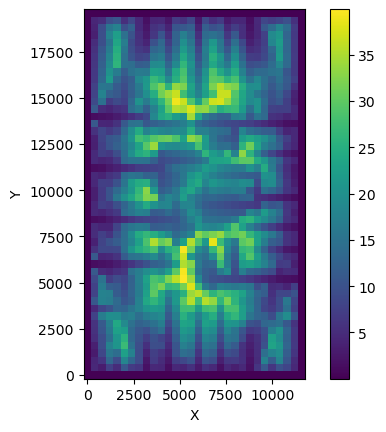

In [14]:
mg.imshow("topographic__elevation", cmap="viridis")

The layers of rock clearly influence the form of topography. 

Next we will use HoloViews to visualize the topography and rock type together. 

To start, we create a HoloViewDataset from our xarray datastructure. 

In [ ]:
hvds_topo = hv.Dataset(ds.topographic__elevation)
hvds_rock = hv.Dataset(ds.rock_type__id)
hvds_topo

Next we specify that we want two images, one showing rock type and one showing topographic elevation. A slider bar shows us model time in millions of years.  

Be patient. Running this next block may take a moment. HoloViews is rendering an image of all time slices so you can see an animated slider. This is pretty magical (but not instantaneous).  

In [ ]:
%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
topo = hvds_topo.to(hv.Image, ["x", "y"])
rock = hvds_rock.to(hv.Image, ["x", "y"])

topo + rock

We can see the form of the anticline advecting through the topography. Cool!


## Part 3: Creation of Inverted Topography

Here we will explore making inverted topography by eroding Lithology with constant properties for half of the model evaluation time, and then filling Lithology in with resistant material only where the drainage area is large. This is meant as a simple example of filling in valleys with volcanic material. 

All of the details of the options for creating a [Lithology](https://landlab.readthedocs.io/en/release/landlab.components.lithology.html) can be found here. 

In the next code block we make a new model and run it. There are a few important differences between this next example and the one we just worked through in Part 2. 

Here we will have two rock types. Type `0` that represents non-volcanic material. It will have a higher diffusivity and erodability than the volcanic material, which is type `1`. 

Recall that in Part 2 we did not specify a `rock_id` keyword argument to the `lith.run_one_step` method. This was because we used only the FastscapeEroder component which is fully detachment limited and thus never deposits material. In this example we will also use the LinearDiffuser component, which may deposity material. The `Lithology` component needs to know the rock type everywhere and thus we must indicate the rock type of the newly deposited rock. This is done by passing a single value or number-of-nodes sized array rock type values to the `run_one_step` method. 

We also are handling the model grid boundary conditions differently than in the last example, setting the boundaries on the top and bottom to closed. 

In [ ]:
mg2 = RasterModelGrid((30, 30), 200)
mg2.set_closed_boundaries_at_grid_edges(False, True, False, True)
z2 = mg2.add_zeros("topographic__elevation", at="node")
random_field = 0.01 * np.random.randn(mg2.size("node"))
z2 += random_field - random_field.min()

thicknesses2 = [10000]
ids2 = [0]

attrs2 = {"K_sp": {0: 0.0001, 1: 0.00001}, "D": {0: 0.4, 1: 0.001}}

lith2 = Lithology(mg2, thicknesses2, ids2, attrs=attrs2)

nts = 500
U = 0.005
dt = 1000

fa2 = FlowAccumulator(mg2)
sp2 = FastscapeEroder(mg2, K_sp="K_sp")
ld2 = LinearDiffuser(mg2, linear_diffusivity="D")

out_fields = ["topographic__elevation", "rock_type__id"]

out_fields = ["topographic__elevation", "rock_type__id"]

nts = 200
U = 0.001
dt = 1000

ds2 = xr.Dataset(
    data_vars={
        "topographic__elevation": (
            ("time", "y", "x"),
            np.empty((nts, mg2.shape[0], mg2.shape[1])),
            {"units": "meters", "long_name": "Topographic Elevation"},
        ),
        "rock_type__id": (
            ("time", "y", "x"),
            np.empty((nts, mg2.shape[0], mg2.shape[1])),
            {"units": "-", "long_name": "Rock Type ID Code"},
        ),
    },
    coords={
        "x": (("x"), mg2.x_of_node.reshape(mg2.shape)[0, :], {"units": "meters"}),
        "y": (("y"), mg2.y_of_node.reshape(mg2.shape)[:, 1], {"units": "meters"}),
        "time": (
            ("time"),
            dt * np.arange(nts) / 1e6,
            {"units": "millions of years since model start", "standard_name": "time"},
        ),
    },
)

half_nts = int(nts / 2)

dz_ad2 = np.zeros(mg2.size("node"))
dz_ad2[mg2.core_nodes] = U * dt
lith2.dz_advection = dz_ad2
lith2.rock_id = 0

for i in range(half_nts):
    fa2.run_one_step()
    sp2.run_one_step(dt=dt)
    ld2.run_one_step(dt=dt)

    z2 += dz_ad2
    lith2.run_one_step()

    for of in out_fields:
        ds2[of][i, :, :] = mg2["node"][of].reshape(mg2.shape)

After the first half of run time, let's look at the topography. 

In [ ]:
mg2.imshow("topographic__elevation", cmap="viridis")

We can see that we have developed ridges and valleys as we'd expect from a model with stream power erosion and linear diffusion. 

Next we will create some volcanic deposits that fill the channels in our model.

In [ ]:
volcanic_deposits = np.zeros(mg2.size("node"))
da_big_enough = mg2["node"]["drainage_area"] > 5e4

topo_difference_from_top = (
    mg2["node"]["topographic__elevation"].max() - mg2["node"]["topographic__elevation"]
)

volcanic_deposits[da_big_enough] = 0.25 * topo_difference_from_top[da_big_enough]
volcanic_deposits[mg2.boundary_nodes] = 0.0

z2 += volcanic_deposits
lith2.rock_id = 1
lith2.run_one_step()

mg2.imshow(volcanic_deposits)

We should expect that the locations of our valleys and ridges change as the river system encouters the much stronger volcanic rock. 

In [ ]:
for i in range(half_nts, nts):
    fa2.run_one_step()
    sp2.run_one_step(dt=dt)
    ld2.run_one_step(dt=dt)
    dz_ad2 = np.zeros(mg2.size("node"))
    dz_ad2[mg2.core_nodes] = U * dt
    z2 += dz_ad2
    lith2.dz_advection = dz_ad2
    lith2.rock_id = 0
    lith2.run_one_step()

    for of in out_fields:
        ds2[of][i, :, :] = mg2["node"][of].reshape(mg2.shape)

Now that the model has run, let's plot the final elevation

In [ ]:
mg2.imshow("topographic__elevation", cmap="viridis")

And now a HoloView Plot that lets us explore the time evolution of the topography

In [ ]:
hvds_topo2 = hv.Dataset(ds2.topographic__elevation)
hvds_rock2 = hv.Dataset(ds2.rock_type__id)

%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
topo2 = hvds_topo2.to(hv.Image, ["x", "y"])
rock2 = hvds_rock2.to(hv.Image, ["x", "y"])

topo2 + rock2

In [ ]:
# if you wanted to output to visualize in something like ParaView, the following commands can be used
# ds.to_netcdf('anticline.nc')
# ds2.to_netcdf('inversion.nc')

Sure enough, the volcanic deposits impact the location of the ridges and valleys. The old valleys become ridges because it takes so much time for them to be eroded. 

You can explore how this changes as the thickness of the deposit changes and as the relative erodabilities change. 


## The end.

Nice work getting to the end of the tutorial!

For more detailed information about the [Lithology](https://landlab.readthedocs.io/en/release/landlab.components.lithology.html) and [LithoLayers](https://landlab.readthedocs.io/en/release/landlab.components.litholayers.html) objects, check out their detailed documentation. 

# **Click [here](https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html) for more Landlab tutorials**